# Preparazione


In [1]:
# importo tutti i pacchetti necessari al progetto
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
from tqdm import tqdm
import copy

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate
from sklearn.utils import resample
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from sklearn.datasets import load_diabetes

np.random.seed(17)

In [2]:
# ottengo la colormap e i colori per i grafici
cmap = plt.get_cmap("viridis")
colors = cmap(np.linspace(0, 1, 11))

In [3]:
# imposto l'opzione display.float_format per evitare le annotazioni scientifiche
pd.set_option('display.float_format', '{:.3f}'.format)

In [4]:
# importo il dataset
diabetes = load_diabetes(as_frame=True)["frame"]

# Analisi esplorativa

Dalla documentazione ho le seguenti informazioni:

Data Set Characteristics:

Number of Instances:  
442


Number of Attributes:  
First 10 columns are numeric predictive values

Target:  
Column 11 is a quantitative measure of disease progression one year after baseline

Attribute Information:  
age in years,  
sex,  
bmi body mass index,  
bp average blood pressure,  
s1 tc, total serum cholesterol,  
s2 ldl, low-density lipoproteins,  
s3 hdl, high-density lipoproteins,  
s4 tch, total cholesterol / HDL,  
s5 ltg, possibly log of serum triglycerides level,  
s6 glu, blood sugar level.

Quindi si tratta di un dataset contenente dati medici di diversi pazieni.

Il target è una misura numerica di quanto la malattia (diabete) è progredita in un anno.

Faccio una breve analisi dei dati per confermare le informazioni trovate nella documentazione.


In [5]:
# mostro il dataframe
diabetes

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038,0.051,0.062,0.022,-0.044,-0.035,-0.043,-0.003,0.020,-0.018,151.000
1,-0.002,-0.045,-0.051,-0.026,-0.008,-0.019,0.074,-0.039,-0.068,-0.092,75.000
2,0.085,0.051,0.044,-0.006,-0.046,-0.034,-0.032,-0.003,0.003,-0.026,141.000
3,-0.089,-0.045,-0.012,-0.037,0.012,0.025,-0.036,0.034,0.023,-0.009,206.000
4,0.005,-0.045,-0.036,0.022,0.004,0.016,0.008,-0.003,-0.032,-0.047,135.000
...,...,...,...,...,...,...,...,...,...,...,...
437,0.042,0.051,0.020,0.060,-0.006,-0.003,-0.029,-0.003,0.031,0.007,178.000
438,-0.006,0.051,-0.016,-0.068,0.049,0.079,-0.029,0.034,-0.018,0.044,104.000
439,0.042,0.051,-0.016,0.017,-0.037,-0.014,-0.025,-0.011,-0.047,0.015,132.000
440,-0.045,-0.045,0.039,0.001,0.016,0.015,-0.029,0.027,0.045,-0.026,220.000


Il Dataframe è composto da 442 samples e da 11 colonne (10 features ed un target)

A prima vista tutte le features sembrano numeriche continue a parte sex.
Il target sembra essere numerico continuo.

Approfondisco l'analisi:

In [6]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
 10  target  442 non-null    float64
dtypes: float64(11)
memory usage: 38.1 KB


In [7]:
# verifico presenza di zeri
diabetes.eq(0).sum()

age       0
sex       0
bmi       0
bp        0
s1        0
s2        0
s3        0
s4        0
s5        0
s6        0
target    0
dtype: int64

In [8]:
diabetes.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
count,442.000,442.000,442.000,442.000,442.000,442.000,442.000,442.000,442.000,442.000,442.000
mean,-0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,152.133
std,0.048,0.048,0.048,0.048,0.048,0.048,0.048,0.048,0.048,0.048,77.093
min,-0.107,-0.045,-0.090,-0.112,-0.127,-0.116,-0.102,-0.076,-0.126,-0.138,25.000
25%,-0.037,-0.045,-0.034,-0.037,-0.034,-0.030,-0.035,-0.039,-0.033,-0.033,87.000
50%,0.005,-0.045,-0.007,-0.006,-0.004,-0.004,-0.007,-0.003,-0.002,-0.001,140.500
75%,0.038,0.051,0.031,0.036,0.028,0.030,0.029,0.034,0.032,0.028,211.500
max,0.111,0.051,0.171,0.132,0.154,0.199,0.181,0.185,0.134,0.136,346.000


Tutti i dati sono numerici (float64) e non ci sono nè zeri ne valori mancanti.

Grazie alla documentazione so che i dati sono stati centrati sulla media di ogni colonna e scalati dalla deviazione standard per la radice quadrata di n_campioni (cioè la somma dei quadrati di ogni colonna è uguale a 1).

Il target è composto da valori numerici che vanno da un minimo valore di 25 ad uno massimo di 346.

## Outliers

Cerco possibili outliers visualizzando un boxplot


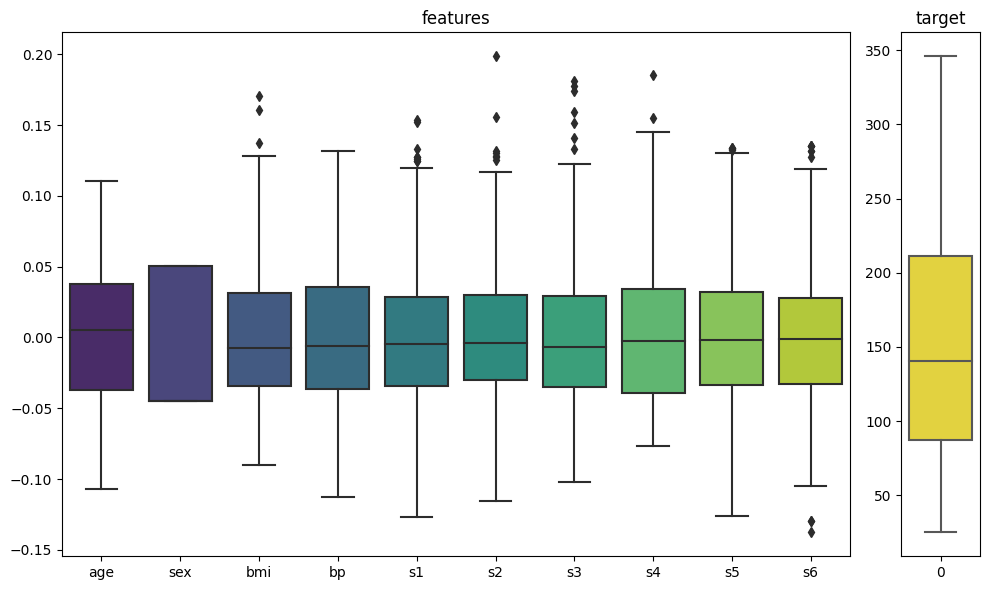

In [9]:
# imposto il grafico
fig, axs = plt.subplots(figsize=(10, 6), width_ratios=[10,1], ncols=2)

# creo il boxplot delle features
sns.boxplot(
    data=diabetes.drop(columns="target"),
    palette="viridis",
    ax=axs[0])

axs[0].set_title("features")

# creo il boxplot del target
sns.boxplot(
    data=diabetes["target"],
    color=colors[10],
    ax=axs[1])

axs[1].set_title("target")
plt.tight_layout()


Il grafico mostra la presenza di outliers nelle features.

Sono presenti nella maggior parte delle features e quasi tutti superano il limite superiore (terzo quartile + 1.5 x IQR).

Questo indica una distribuzione dei dati con coda a destra che porta a sovrastimare la media come indice di tendenza centrale.
La mediana in questo caso riassume meglio i dati.

Il target non sembra avere outliers.


## Distribuzioni

osservo le distribuzioni delle features e del target

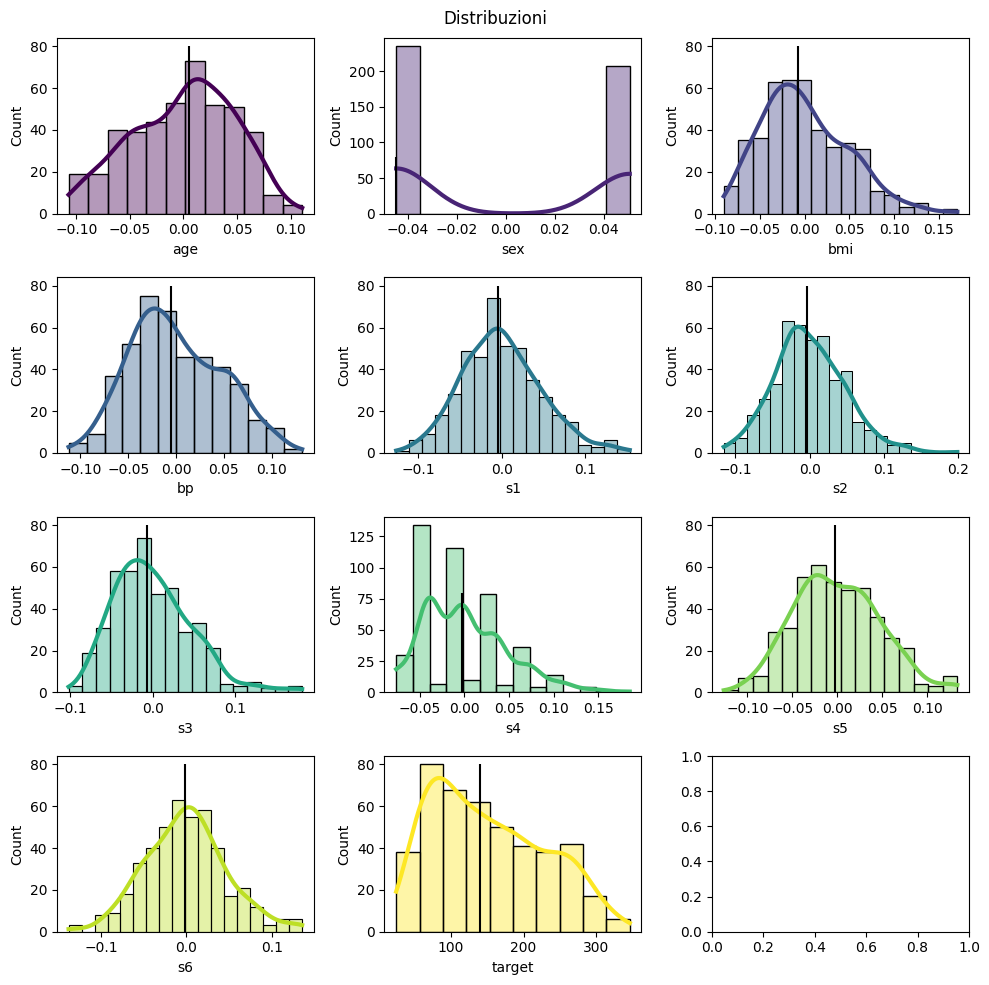

In [10]:
# grafico boxplot e della distribuzione del target
fig, axs = plt.subplots(
    figsize=(10, 10),
    nrows=4,
    ncols=3
)

axs = axs.ravel()

# imposto histplot
for i, col in enumerate(diabetes.columns):
    sns.histplot(
        diabetes,
        x=diabetes[col],
        color=colors[i],
        ax=axs[i],
        kde=True,
        line_kws={"linewidth": 3},
        alpha=0.4
    )
    # traccio mediana
    axs[i].vlines(
        diabetes[col].median(),
        ymin=0,
        ymax=80,
        color="k")

plt.suptitle("Distribuzioni")

plt.tight_layout()

I grafici delle distribuzioni mostrano che le features bmi, s2, s3 ed s4 hanno una distribuzione con coda a destra abbastanza accentuata.

Il target ha una distribuzione con coda a destra.

Si può notare infine la natura categorica della feature "sex". I dati infatti sono concentrati solamente su due valori (maschio e femmina).

## Features Categoriche


Vado ad approfondire l'analisi dei dati sulla colonna "sex" in quanto, essendo questa una variabile binaria categorica, è necessario analizzarla in modo differenti dalle altre features.

Per approfondire l'analisi di questa feature vado a creare un grafico della distribuzione dei due sessi rispetto ai valori di target.
Questo mi permette di osservare se ci sono differenze significative tra le due categorie, maschio e femmina, in relazione all'andamento dei valori del target.

Non sapendo quale dato corrisponda a Maschio e Femmina lascio come etichetta sex_neg e sex_pos.


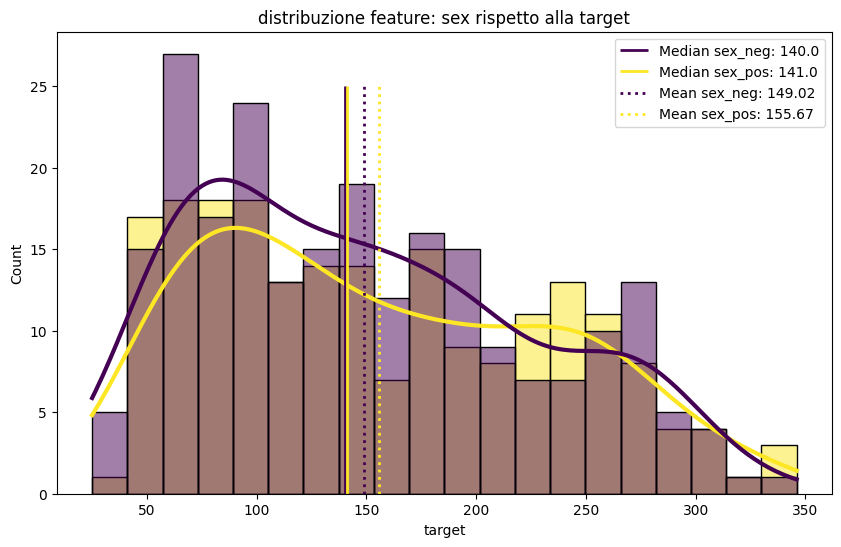

In [11]:
# imposto dimensioni grafico
plt.figure(figsize=(10, 6))

# creo il grafico della distribuzione del sesso rispetto al target
sns.histplot(
    diabetes,
    x="target",
    hue="sex",
    bins=20,
    kde=True,
    palette="viridis",
    alpha=0.5,
    legend=False,
    line_kws={"linewidth": 3},
)

# calcolo mediana e media
median_neg = round(
    diabetes.loc[diabetes["sex"] < 0, "target"].median(),
    2
)
median_pos = round(
    diabetes.loc[diabetes["sex"] > 0, "target"].median(),
    2
)
mean_neg = round(
    diabetes.loc[diabetes["sex"] < 0, "target"].mean(),
    2
)
mean_pos = round(
    diabetes.loc[diabetes["sex"] > 0, "target"].mean(),
    2
)

# traccio mediana e media sul grafico
plt.vlines(
    median_neg,
    ymin=0,
    ymax=25,
    linestyle="solid",
    color=colors[0],
    linewidth=2,
    label=f"Median sex_neg: {median_neg}",
)
plt.vlines(
    median_pos,
    ymin=0,
    ymax=25,
    linestyle="solid",
    colors=colors[10],
    linewidth=2,
    label=f"Median sex_pos: {median_pos}",
)
plt.vlines(
    mean_neg,
    ymin=0,
    ymax=25,
    linestyle="dotted",
    colors=colors[0],
    linewidth=2,
    label=f"Mean sex_neg: {mean_neg}",
)
plt.vlines(
    mean_pos,
    ymin=0,
    ymax=25,
    linestyle="dotted",
    colors=colors[10],
    linewidth=2,
    label=f"Mean sex_pos: {mean_pos}",
)

plt.legend()
plt.title("distribuzione feature: sex rispetto alla target")

plt.show()

Il grafico mostra un andamento della distribuzione simile per entrambi i sessi.

La mediana è molto simile per entrambi i sessi, per sex_neg è 140 e 141 per sex_pos.

La media vale 149 per sex_neg e 155.67 per sex_pos.

La classe sex_pos sembra meno rappresentata di sex_neg, vado a contare i campioni con sex_pos e quelli con sex_neg.


In [12]:
# conto valori sex
diabetes["sex"].value_counts()

-0.045    235
0.051     207
Name: sex, dtype: int64

Creo un grafico a torta per visualizzare meglio la differenza tra i due sessi.


Text(0.5, 1.0, 'percentuale feature sex')

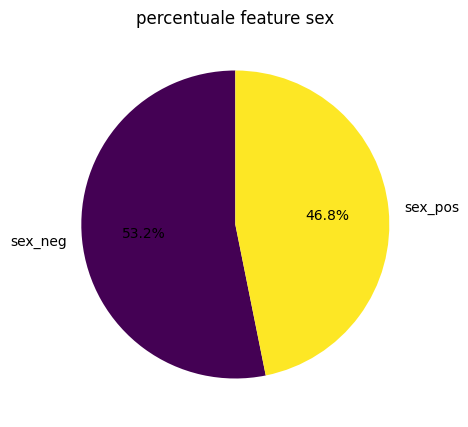

In [13]:
# dati per il grafico a torta
labels = ["sex_neg", "sex_pos"]
sizes = [
    diabetes["sex"].value_counts().values[0],
    diabetes["sex"].value_counts().values[1],
]

# creo il grafico a torta
plt.figure(figsize=(5, 5))
plt.pie(
    sizes,
    labels=labels,
    colors=(colors[0], colors[10]),
    autopct="%1.1f%%",
    startangle=90,
)

plt.title("percentuale feature sex")

I campioni sex_neg sono 235 mentre quelli sex_pos sono 207. Una differenza di 28 campioni su un totale di 442.

sex_neg sono quindi il 53.2% dei campioni mentre sex_pos sono il restante 46.8%

## Correlazioni


Calcolo le correlazioni tra le features per evitare un possibile problema di multicollinearità.

Utilizzo il metodo di Pearson per identificare correlazioni lineari tra le features e quindi la possibilità di multicollinearità.


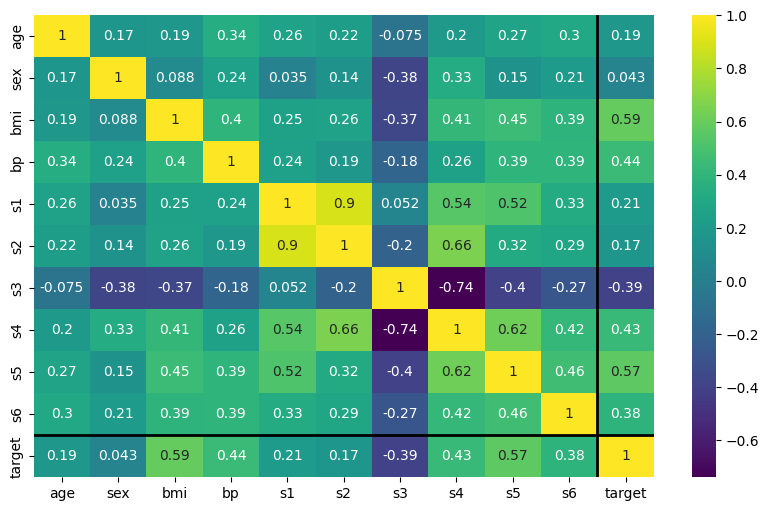

In [14]:
# creo la matrice di correlazione
matrix = diabetes.corr(method="pearson")

# imposto il grafico
plt.figure(figsize=(10,6))

# creo il grafico
sns.heatmap(matrix,
            cmap="viridis",
            annot=True
           )

# evidenzio il "target" con due linee
plt.axvline(x=10,
            color="k",
            linewidth=2
           ) # linea verticale
plt.axhline(y=10,
            color="k",
            linewidth=2
           ) # linea orizzontale

La tabella mostra l'indice di correlazione tra i dati calcolato con il metodo di Pearson.

La matrice di correlazione mostra che alcune features hanno un certo grado di correlazione, in particolare "s1" ed "s2" sono molto correlate positivamente (0.9).

Questo potrebbe portare ad un problema di multicollinearità.


Le features maggiormente correlate con il target sono "bmi" e "s5".

"s3" è l'unica feature correlata negativamente con il target.

I valori di correlazione tra features e target non sono molto alti.
Questo può indicare una bassa prevedibilità del dataset oppure una correlazione non lineare.

## Relazioni Features/Target

Rappresento graficamente le features creando uno scatter plot features/target

Usando sns.regplot() oltre allo scatter plot rappresento una linea di regressione polinomiale con grado a scelta.

In questo caso provo ad usare un grado=3 che sembra rappresentare bene i dati.


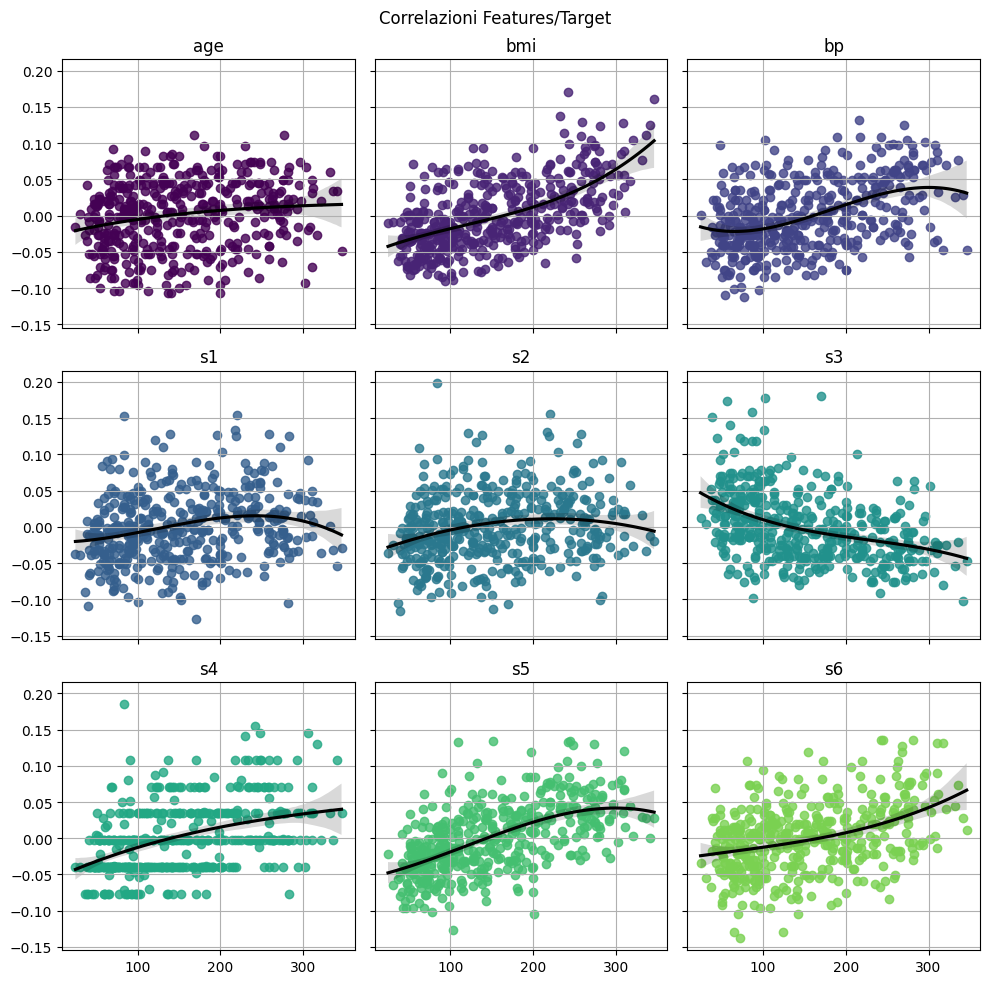

In [15]:
# imposto il grafico
fig, axs = plt.subplots(
    nrows=3,
    ncols=3,
    figsize=(10, 10),
    sharex=True,
    sharey=True
)
axs = axs.ravel()

# itero attraverso le colonne del DataFrame per creare i diversi assi
for idx, column in enumerate(
    diabetes.columns[[0, 2, 3, 4, 5, 6, 7, 8, 9]]
):  # prendo solo le colonne di mio interesse
    sns.regplot(
        data=diabetes,
        x="target",
        y=column,
        color=colors[idx],
        line_kws={"color": "k"},
        order=3,
        ax=axs[idx],
    )

    axs[idx].set_title(column)
    axs[idx].set_xlabel("")
    axs[idx].set_ylabel("")
    axs[idx].grid()

# imposto titolo e layout
plt.suptitle(
    "Correlazioni Features/Target",
    horizontalalignment="center"
)
plt.tight_layout()


I regplot permettono di osservare meglio le possibili correlazioni tra le feature e il target. Si possono notare possibili correlazioni positive per le features "bmi", "s5", "bp" ed "s6", ed una possibile correlazione negativa per "s3".


## Conclusioni analisi esplorativa

L'analisi esplorativa mostra 3 possibili problematiche che potrebbero andare ad inficiare l'efficienza dell'addestramento del modello:
- sono presenti outliers nelle features
- la feature "sex" è leggermente sbilanciata a favore di "sex_neg"
- le features "s1" ed "s2" sono molto correlate tra loro. Rischio di multicollinearità.

# Scelta del modello


Le caratteristiche principali del dataset sono le seguenti:

- dimensioni ridotte (meno di 500 samples)
- target numerico e continuo --> REGRESSIONE
- features principalmente numeriche continue ed una categorica binaria ("sex")
- sono presenti outliers nelle features
- alcune features sono molto correlate tra loro --> rischio multicollinearità
- le features hanno basso indice di correlazione con il target --> correlazioni non lineari o dati poco prevedibili


In base a queste considerazioni penso che il modello migliore da utilizzare sia **Random Forest** in quanto:

- la sua natura di ensamble lo rende versatile ed accurato
- può gestire sia variabili continue che categoriche
- poco sensibile agli outliers e a dati rumorosi
- risente poco della multicollinearità
- riesce a identificare correlazioni non lineari
- incorpora tecniche per la riduzione dell'overfitting (bootstrap)
- è di facile interpretazione grazie ad esempio alla possibilità di analizzare l'importanza delle features


# Set split


Il dataset è composto da 442 campioni (righe) e da 10 features (colonne).

Divido il dataset in training set e test set in modo da poter analizzare ed addestrare il modello su una porzione di dati e poter successivamente testare le predizioni del modello sul test set.



In [16]:
# divido il dataset tra features (X) e target (y)
X = diabetes.drop(columns="target")
y = diabetes["target"]

In [17]:
# divido il daset in training_set e test_set
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=17
)

Vista la bassa dimensionalità del dataset e che il caso potrebbe incidere notevolmente sull'addestramento del modello, verifico che lo split casuale abbia generato un training set rappresentativo dell'intero dataset.

Per fare ciò confronto le distribuzioni di y e di y_train.

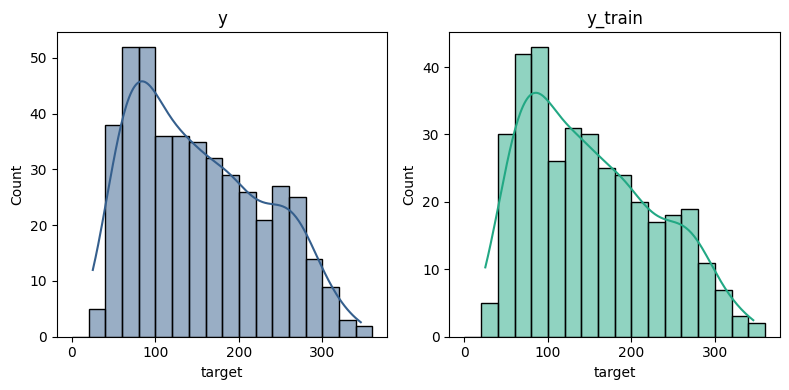

In [18]:
# imposto il grafico
fig, axs = plt.subplots(
    figsize=(8,4),
    ncols=2
)

# dataset intero
sns.histplot(
    y,
    kde=True,
    ax=axs[0],
    color=colors[3],
    binwidth=20,
    binrange=(0, 350)
)
axs[0].set_title("y")

# dataset addestramento
sns.histplot(
    y_train,
    kde=True,
    ax=axs[1],
    color=colors[6],
    binwidth=20,
    binrange=(0, 350)
)
axs[1].set_title("y_train")

plt.tight_layout()

In [19]:
X_train.shape

(353, 10)

In [20]:
X_test.shape

(89, 10)

I nuovi dataset creati sono formati rispettivamente da 353 campioni (train) e da 89 campioni (test).

y_train sembra avere una distribuzione simile ad y.

y_train quindi dovrebbe riuscire a rappresentare bene l'intero dataset, permettendo al modello di addestrarsi correttamente.

# Baseline model

Definisco un baseline model con iperparametri di default in modo da avere una prima idea di come si addestra il modello e di conseguenza come modificare gli iperparametri per migliorare il fit.

L'unico iperparametro che modifico rispetto all'impostazione standard è oob_score che imposto su True. Oob_score permette di calcolare il punteggio sui dati esclusi dal bootstrap (out of bag) e non incide sull'andamento dell'addestramento.

In [21]:
# defiisco il modello RF
baseline_model = RandomForestRegressor(
                n_estimators=100,
                criterion="squared_error",
                max_depth=None,
                min_samples_split=2,
                min_samples_leaf=1,
                min_weight_fraction_leaf=0.0,
                max_features=1.0,
                max_leaf_nodes=None,
                min_impurity_decrease=0.0,
                bootstrap=True,
                oob_score=True,
                n_jobs=None,
                random_state=17,
                verbose=0,
                warm_start=False,
                ccp_alpha=0.0,
                max_samples=None,
)

In [22]:
# addestro il baseline model -> (Fitted Base Line model)
baseline_model.fit(X_train, y_train)

RandomForestRegressor(oob_score=True, random_state=17)

In [23]:
# predico test e train
y_pred_bl = baseline_model.predict(X_test)  # predizione test
y_pred_train_bl = baseline_model.predict(X_train)  # predizione train

Utilizzo due metriche per valutare l'errore: **R2 e mean absolute percentage errore (MAPE)** in quanto sono misure relative e permettono facilmente di osservare l'esito dell'addestramento.

R2 rappresenta la percentuale di varianza del target che può essere spiegata dalle variabili indipendenti del modello.
Valori di R2 vicini ad 1 indicano che la varianza è poca e quindi che il modello riesce a generalizzare bene sull'andamento dei dati.

Mean Absolute Percentage Error (MAPE) fornisce una stima dell'errore medio del modello, misurato in percentuale della variabile dipendente.
Valori di MAPE vicino a 0 indicano che l'errore assoluto medio è poco, quindi il modello riesce a prevedere bene l'andamento del target.

Inoltre calcolo il oob_score (Out of Bag score), usando come metrica R2, in modo da avere un riferimento per l'ottimizzazione degli iperparametri che effettuerò successivamente.

Utilizzo oob_score perchè mi permette di avere un punteggio su dati su cui il modello non si è addestrato direttamente con il fitting (simile al punteggio su un validation set ma senza dover splittare il dataset).

Per calcolare l'oob_score vengono presi i campioni scartati durante il bootstrapping della Random Forest. Vengono quindi utilizzati dati non presi per l'addestramento.

Tuttavia, le previsioni sui dati oob potrebbero risultare leggermente ottimistiche rispetto a quelle effettuate su un validation set o un test set ma saranno comunque utili per paragonare i vari risultati ottenuti.

In [24]:
# calcolo punteggi
R2_score = round(
    r2_score(y_test, y_pred_bl),
    3
)
MAPE_score = round(
    mean_absolute_percentage_error(y_test, y_pred_bl),
    3
)
R2_train_score = round(
    r2_score(y_train, y_pred_train_bl),
    3
)
MAPE_train_score = round(
    mean_absolute_percentage_error(y_train, y_pred_train_bl),
    3
)
R2_OOB_score = round(
    baseline_model.oob_score_,
    3
)

# stampo risultati
print(f"R2 train:    {R2_train_score}")
print(f"R2 test:     {R2_score}")
print("")
print(f"MAPE train:  {MAPE_train_score}")
print(f"MAPE test:   {MAPE_score}")
print("")
print(f"R2 OOB:      {R2_OOB_score}")

R2 train:    0.92
R2 test:     0.437

MAPE train:  0.149
MAPE test:   0.389

R2 OOB:      0.424


Gli iperparametri predefiniti non permettono al modello di prevedere correttamente l'anadmento dei dati.



I punteggi di R2 e MAPE ottenuti indicano un relativamente basso bias ma una alta varianza --> OVERFITTING


# Processing dati

vado a "pulire" i dati andando a risolvere le problematiche evidenziate nella fase di analisi esplorativa.

Eseguo tutte le operazioni di pulizia dei dati solamente sul train set in modo da non corrompere in test set.

## Outliers imputation

Vado a sostituire gli outliers in modo da lavorare con dati più puliti.

Vista la scarsa dimensionalità del dataset non rimuovo i campioni con outliers ma vado a sostituire i singoli dati con la mediana della colonna.

Vado ad eseguire la sostituzione degli outliers solo nel set di addestramento per non corrompere il set di test.

In [25]:
# creo una series di appoggio
index_series = pd.Series(
    [],
    dtype="float64"
)

# creo una copia del dataset
X_train_2 = X_train.copy()

# itero sia sulle colonne che sulle righe per accedere ai dati
for column in X_train.columns:
    for i, n in enumerate(X_train[column]):
        # identifico i margini in cui accettare i dati
        q1 = X_train[column].quantile(0.25) # primo quartile
        q3 = X_train[column].quantile(0.75) # terzo quartile
        iqr = q3 - q1
        lower_tail = q1 - 1.5 * iqr # limite inferiore
        upper_tail = q3 + 1.5 * iqr # limite superiore

        # se identifico un outlier
        if n > upper_tail or n < lower_tail:
            # aggiungo l'indice alla serie
            index_series = pd.concat([index_series, pd.Series(i)])
            # sostituisco il valore con la mediana
            X_train_2[column] = X_train_2[column].replace(
                n,
                np.median(X_train_2[column])
            )

Ricreo un boxplot delle features per verificare che la modifica sia andata a buon fine

Text(0.5, 1.0, 'X_train_2')

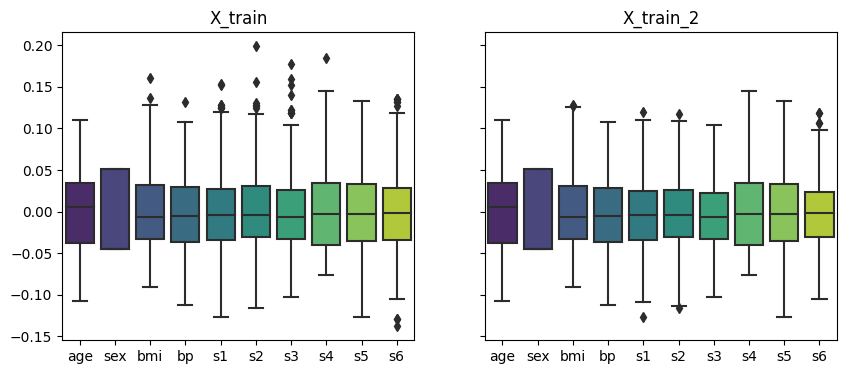

In [26]:
# imposto il grafico
fig, axs = plt.subplots(
    ncols=2,
    figsize=(10,4),
    sharey=True
)

# creo i boxplot delle features
sns.boxplot(
    data=X_train,
    palette="viridis",
    ax = axs[0]
    )

axs[0].set_title("X_train")

sns.boxplot(
    data=X_train_2,
    palette="viridis",
    ax = axs[1]
    )

axs[1].set_title("X_train_2")

In [27]:
# conto numero di dati sostituiti
index_series.count()

35

In [28]:
# identifico a quali campioni appartengono gli outliers
index_series.value_counts().head(10)

174    3
129    2
163    2
209    2
242    2
138    1
161    1
333    1
97     1
111    1
dtype: int64

In totale **sono stati sostituiti 35 valori risultati outliers** che, su un totale di 3530 dati (353 samples x 10 features) rappresentano lo **0,99% dei dati totali**.

I dati sostituiti raramente appartengono allo stesso campione. Solo un campione ha 3 dati sostituiti. Non è quindi necessario rimuovere campioni in quanto rimangono dati a sufficienza per rendere i campioni consistenti.

### Addestramento modello

In [29]:
# creo una copia del modello da riaddestrare
bl_model_2 = copy.deepcopy(baseline_model)

# addestro il baseline model sul training set
bl_model_2.fit(X_train_2, y_train)

RandomForestRegressor(oob_score=True, random_state=17)

In [30]:
# predico test e train
y_pred_bl_2 = bl_model_2.predict(X_test)  # predizione test
y_pred_train_bl_2 = bl_model_2.predict(X_train_2)  # predizione train

In [31]:
# calcolo punteggi
R2_score_2 = round(
    r2_score(y_test, y_pred_bl_2),
    3
)
MAPE_score_2 = round(
    mean_absolute_percentage_error(y_test, y_pred_bl_2),
    3
)
R2_train_score_2 = round(
    r2_score(y_train, y_pred_train_bl_2),
    3
)
MAPE_train_score_2 = round(
    mean_absolute_percentage_error(y_train, y_pred_train_bl_2),
    3
)
R2_OOB_score_2 = round(
    bl_model_2.oob_score_,
    3
)

# stampo risultati
print(f"R2 train:    {R2_train_score_2}")
print(f"R2 test:     {R2_score_2}")
print("")
print(f"MAPE train:  {MAPE_train_score_2}")
print(f"MAPE test:   {MAPE_score_2}")
print("")
print(f"R2 OOB:      {R2_OOB_score_2}")

R2 train:    0.919
R2 test:     0.408

MAPE train:  0.148
MAPE test:   0.405

R2 OOB:      0.42


I punteggi sono leggermente peggiori rispetto a prima.

Probabilmente in questo caso gli outliers portano informazioni utili alla previsione del target.

Mantengo per ora il dataset originale "X_train"

## Data Augmentation


Aumento artificialmente i campioni con valore di "sex" positivo (sex_pos) in modo da bilanciare le classi.

Uso la funzione resample di sklearn per bilanciare la classe "sex".
La funzione mi permette di eseguire il bootstrap del dataset, ovvero di ottenere n campioni casuali presi con sostituzione.
Prendo i campioni della classe meno rappresentata (sex_pos) in modo da poter pareggiare il numero di campioni appertenete alle due classi.

Prima di tutto unisco X_train e y_train in un unico dataset in modo da aumentare i campioni sia in X che in y in una volta sola

In [32]:
# unisco X_train e y_train
diabetes_train =  pd.concat(
    [X_train, y_train],
    axis=1
)
diabetes_train.sample()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
1,-0.002,-0.045,-0.051,-0.026,-0.008,-0.019,0.074,-0.039,-0.068,-0.092,75.000


Conto i campioni con sex_neg e sex_pos nel dataset diabetes_train

In [33]:
# conto campioni sex_pos
new_sex_pos = diabetes_train.loc[
    diabetes_train["sex"] > 0,
    "sex"
].count()
print("campioni sex_pos: ", new_sex_pos)

campioni sex_pos:  160


In [34]:
# conto campioni sex_neg
new_sex_neg = diabetes_train.loc[
    diabetes_train["sex"] < 0,
    "sex"
].count()
print("campioni sex_neg: ", new_sex_neg)

campioni sex_neg:  193


In [35]:
# calcolo di quanto aumentare la classe sex_pos
n_samples = abs(
    diabetes_train["sex"].value_counts().values[0] -
    diabetes_train["sex"].value_counts().values[1]
)
# aggiungo i campioni mancanti
X_train_boot = resample(
    diabetes_train.loc[diabetes_train["sex"] > 0],
    n_samples=n_samples,
    replace=True,
    random_state=17
)

# unisco i campioni al dataset e resetto gli indici
diabetes_train_aug = pd.concat([diabetes_train, X_train_boot]
                          ).reset_index(drop=True)

Riconto i campioni con sex_neg e con sex_pos dopo la ricampionatura

In [36]:
# conto campioni sex_pos
new_sex_pos = diabetes_train_aug.loc[
    diabetes_train_aug["sex"] > 0,
    "sex"
].count()
print("campioni sex_pos: ", new_sex_pos)

campioni sex_pos:  193


In [37]:
# conto campioni sex_neg
new_sex_neg = diabetes_train_aug.loc[
    diabetes_train_aug["sex"] < 0,
    "sex"
].count()
print("campioni sex_neg: ", new_sex_neg)

campioni sex_neg:  193


In [38]:
# numero dei campioni totali
diabetes_train.shape

(353, 11)

divido nuovamente il dataset in X e y

In [39]:
X_train_3 = diabetes_train_aug.drop(columns="target")
y_train_3 = diabetes_train_aug["target"]

Rappresento graficamente con un grafico a torta

Text(0.5, 1.0, 'X_train_3')

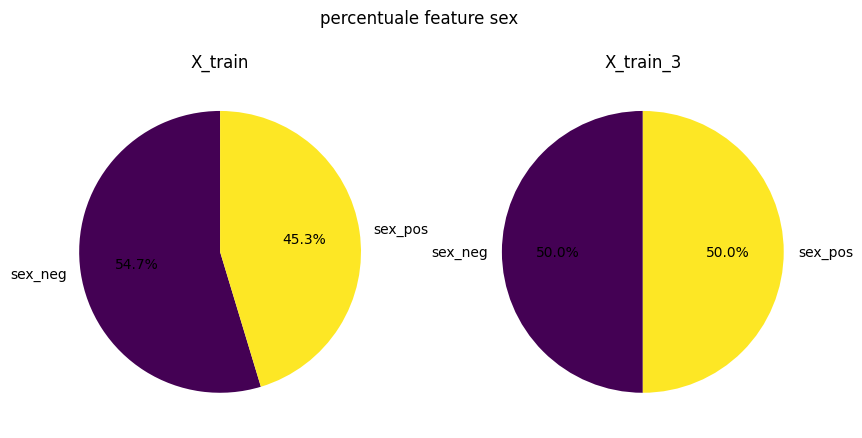

In [40]:
# dati per il grafico a torta
labels = ["sex_neg", "sex_pos"]
sizes_old = [
    X_train["sex"].value_counts().values[0],
    X_train["sex"].value_counts().values[1],
]

sizes_new = [new_sex_neg, new_sex_pos]

# impostografico a torta
fig, axs = plt.subplots(
    ncols=2,
    figsize=(10, 5)
)

# titolo
plt.suptitle("percentuale feature sex")

# imposto grafico X_train_2
axs[0].pie(
    sizes_old,
    labels=labels,
    colors=(colors[0], colors[10]),
    autopct="%1.1f%%",
    startangle=90,
)

axs[0].set_title("X_train")

# imposto grafico X_train_3
axs[1].pie(
    sizes_new,
    labels=labels,
    colors=(colors[0], colors[10]),
    autopct="%1.1f%%",
    startangle=90,
)

axs[1].set_title("X_train_3")

Il numero dei campioni totali è aumentato da 353 a 386.

Nel nuovo dataset "X_train_3" i sessi sono rapresentati ugualmente (193 campioni per ogni sesso)


### Addestramento modello

In [41]:
# creo una copia del baseline_model
bl_model_3 = copy.deepcopy(baseline_model)

# addestro il baseline model sul training set
bl_model_3.fit(X_train_3, y_train_3)

RandomForestRegressor(oob_score=True, random_state=17)

In [42]:
# predico test e train
y_pred_bl_3 = bl_model_3.predict(X_test)  # predizione test
y_pred_train_bl_3 = bl_model_3.predict(X_train_3)  # predizione train

In [43]:
# calcolo punteggi
R2_score_3 = round(
    r2_score(y_test, y_pred_bl_3),
    3
)
MAPE_score_3 = round(
    mean_absolute_percentage_error(y_test, y_pred_bl_3),
    3
)
R2_train_score_3 = round(
    r2_score(y_train_3, y_pred_train_bl_3),
    3
)
MAPE_train_score_3 = round(
    mean_absolute_percentage_error(y_train_3, y_pred_train_bl_3),
    3
)
R2_OOB_score_3 = round(
    bl_model_3.oob_score_,
    3
)

# stampo risultati
print(f"R2 train:    {R2_train_score_3}")
print(f"R2 test:     {R2_score_3}")
print("")
print(f"MAPE train:  {MAPE_train_score_3}")
print(f"MAPE test:   {MAPE_score_3}")
print("")
print(f"R2 OOB:      {R2_OOB_score_3}")

R2 train:    0.931
R2 test:     0.426

MAPE train:  0.135
MAPE test:   0.387

R2 OOB:      0.505


I punteggi sono leggermente peggiorati rispetto al primo addestramento.

(L'oob_score è migliorato ma in questo caso ha molta meno rilevanza rispetto ai punteggi ottenuti sul set di test.)

Probabilmente visto il basso numero di campioni aggiunti ed il poco sbilanciamento della features "sex" il peggioramento delle prestazioni del modello è dovuto al caso.
Potrebbe inoltre esserche che la data augmentation modifichi leggermente la distribuzione del dataset e di conseguenza la capacità del modello di addestrarsi correttamente.

Mantengo il dataset originale "X_train" e "y_train"

## Gestione Multicollinearità

Dalla tabella delle correlazioni creata durante l'analisi esplorativa si nota che le features "s1" ed "s2" sono molto correlata tra loro.

Provo ad eliminarne una delle due per evitare il rischio di multicollinearità e provare ad aumentare l'efficienza del modello.

In [44]:
# ottengo l'importanza delle features
for i, col in enumerate(X_train.columns):
    print(col, round(baseline_model.feature_importances_[i], 3))

age 0.057
sex 0.02
bmi 0.23
bp 0.099
s1 0.043
s2 0.05
s3 0.047
s4 0.02
s5 0.371
s6 0.062


s1 sembra leggermente meno rilevante per il modello rispetto ad s2.

Provo ad eliminare s1 e osservo se ci sono miglioramenti nell'addestramento.

Elimino s1 anche dal set test.

In [45]:
X_train_4 = X_train.drop(columns="s1")
X_train_4.sample()

,age,sex,bmi,bp,s2,s3,s4,s5,s6
297,0.002,-0.045,-0.008,-0.064,-0.024,0.004,-0.039,-0.065,-0.055


In [46]:
X_test_4 = X_test.drop(columns="s1")
X_test_4.sample()

,age,sex,bmi,bp,s2,s3,s4,s5,s6
133,-0.042,0.051,-0.054,-0.040,-0.072,-0.003,-0.039,-0.072,-0.030


### Addestramento modello

In [47]:
# creo una copia del modello baseline_model
bl_model_4 = copy.deepcopy(baseline_model)

# addestro il baseline model sul training set
bl_model_4.fit(X_train_4, y_train)

RandomForestRegressor(oob_score=True, random_state=17)

In [48]:
# predico test e train
y_pred_bl_4 = bl_model_4.predict(X_test_4)  # predizione test
y_pred_train_bl_4 = bl_model_4.predict(X_train_4)  # predizione train

In [49]:
# calcolo punteggi
R2_score_4 = round(
    r2_score(y_test, y_pred_bl_4),
    3
)
MAPE_score_4 = round(
    mean_absolute_percentage_error(y_test, y_pred_bl_4),
    3
)
R2_train_score_4 = round(
    r2_score(y_train, y_pred_train_bl_4),
    3
)
MAPE_train_score_4 = round(
    mean_absolute_percentage_error(y_train, y_pred_train_bl_4),
    3
)
R2_OOB_score_4 = round(
    bl_model_4.oob_score_,
    3
)

# stampo risultati
print(f"R2 train:    {R2_train_score_4}")
print(f"R2 test:     {R2_score_4}")
print("")
print(f"MAPE train:  {MAPE_train_score_4}")
print(f"MAPE test:   {MAPE_score_4}")
print("")
print(f"R2 OOB:      {R2_OOB_score_4}")

R2 train:    0.92
R2 test:     0.434

MAPE train:  0.15
MAPE test:   0.386

R2 OOB:      0.423


I risultati, anche se di poco, sono leggermente peggiorati eliminando "s1" dal dataset.

Probabilmente "s1" apporta informazioni utili per l'apprendimento del modello nonostante la forte correlazione con "s2".

Mantengo il dataset originale X_train, y_train, X_test, y_test.


## Conclusioni processing dati

I tentativi di pulizia e miglioramento dei dati non hanno portato al miglioramento del modello.

Probabilmente questo è dovuto alla bassa dimensionalità del dataset ed alla qualità dei dati.

La pulizia dei dati va inevitabilmente a modificare, anche se in piccola parte, le informazioni contenenti nel dataset. Informazioni che, con questi dati, sono fondamentali per l'apprendimento ottimale del modello.

Mantengo quindi il dataset originale:  
X_train,  
X_test,  
y_train,  
y_test  


# Ottimizzazione iperparametri


Vado ad ottimizzare gli iperparametri del modello facendo cross validation.


definisco i range di dati per ogni iperparametro in base alle problematiche riscontrate fin'ora.

Cerco di ridurre l'overfitting e migliorare le prestazioni del modello.

Scelgo i seguenti iperparametri da validare:

- **n_estimator:** il numero di alberi della foresta. Aumentando il numero di alberi potrebbe ridursi anche l'overfitting.
- **max_features:** il numero di features usate per ogni albero. Riducendo il numero potrebbe diminuire l'overfitting.
- **max_depth:** la profondità massima dell'albero. Anche in questo caso ridure la profondità potrebbe migliorare il risultato.
- **min_sample_split:** il numero minimo di campioni richiesti per dividere un nodo dell'albero. In questo caso aumentare il valore potrebbe migliorare il risultato.
- **min_samples_leaf:** il numero minimo di campioni per ogni foglia. Anche in questo caso, incrementare questo valore potrebbe ridurre l'overfitting.
- **max_samples:** il numero massimo di campioni utilizzati per addestrare gli alberi. Modificare questo parametro potrebbe migliorare l'efficienza numerica del modello.


Trovo la profondità che ha raggiunto il modello con il primo fit in modo da ridurne la profondità


In [50]:
# determino la profondità massima raggiunta
max_depths = [estimator.tree_.max_depth for estimator in baseline_model.estimators_]
print(max(max_depths))

19


## Cross Validation


Imposto gli iperparametri scelti in modo da ridurre l'overfitting e migliorare l'apprendimento del modello sui dati di test.

Utilizzo una RandomSearchCV in modo da testare diverse configurazioni di iperparametri.

Utilizzo R2 come metrica per valutare quali parametri ottengono migliori risultati in quanto è un'ottimo indicatore della varianza (varianza troppo alta è il principale problema attualmente).

Calcolo anche il oob_score in modo da poter confrontare i risultati con baseline_model.

Provo 100 iterazioni del modello per i 5 fold della cross validation (500 tentativi totali).


In [51]:
# definisco il modello
cv_model_1 = RandomForestRegressor(
    random_state=17,
    n_jobs=-1,
    criterion="squared_error",
    bootstrap=True,
    oob_score=True,
    verbose=0
)

# creo lo spazio di validazione degli iperparametri
random_space_1 = {
    # valore predefinito = 100, cerco valori superiori
    "n_estimators": np.arange(
        100,
        1000
    ),
    # valore predefinito = 1.0 ovvero tutte le features, considero meno feature per ogni albero
    "max_features": [
        0.2,
        0.4,
        0.6,
        0.8,
        1.0
    ],
    # valore predefinito = None, riduco la profondità
    "max_depth": np.arange(
        5,
        20
    ),
    # valore predefinito = 2, cerco valori superiori
    "min_samples_split": [
        2,
        4,
        6,
        8,
        10
    ],
    # valore predefinito = 1, cerco valori superiori
    "min_samples_leaf": [
        1,
        3,
        5,
        7,
        9
    ],
    # valore predefinito = None, cerco valori tra 0 e 1.
    "max_samples":[
        0.2,
        0.4,
        0.6,
        0.8,
        1.0
    ]
}

# definisco la ricerca casuale
search_1 = RandomizedSearchCV(
    estimator=cv_model_1,
    param_distributions=random_space_1,
    n_iter=100,  # numero di iterazioni
    n_jobs=-1,
    cv=5,  # cross validation su 5 fold
    return_train_score=True,
    random_state=17,
    scoring="r2",
    refit=True,
    verbose=1,
    error_score='raise'
)
# addestro
cv_result_1 = search_1.fit(X_train, y_train)

# salvo il miglior modello
cv_model_1 = cv_result_1.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


ottengo le informazioni utili sul modello che ha ottenuto il miglior punteggio r2

In [52]:
# migliori parametri
params_1 = cv_result_1.best_params_

# indice del risultato migliore
index_1 = cv_result_1.best_index_

# miglior r2 score sui fold di test
cv_test_r2_1 = round(
    cv_result_1.cv_results_["mean_test_score"][index_1],
    3
)
# media r2 sui fold di train
cv_train_r2_1 = round(
    cv_result_1.cv_results_["mean_train_score"][index_1],
    3
)
# r2 sui dati oob
oob_r2_1 = round(
    cv_model_1.oob_score_,
    3
)

# predico sul set di train per confrontare con bl model
y_pred_train_1 = cv_model_1.predict(X_train)

# calcolo punteggi
R2_train_score_1 = round(
        r2_score(y_train, y_pred_train_1),
        3
)
MAPE_train_score_1 = round(
        mean_absolute_percentage_error(y_train, y_pred_train_1),
        3
)

#stampo a schermo
print(f"parametri: {params_1}")
print("")
print(f"miglior indice:                  {index_1}")
print(f"media di r2 sui fold di train:   {cv_train_r2_1}")
print(f"media di r2 sui fold di test:    {cv_test_r2_1}")
print(f"r2 sui dati OOB:                 {oob_r2_1}")
print(f"punteggio R2 sul set di train:   {R2_train_score_1}")
print(f"punteggio MAPE sul set di train: {MAPE_train_score_1}")


parametri: {'n_estimators': 159, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_samples': 0.6, 'max_features': 1.0, 'max_depth': 10}

miglior indice:                  36
media di r2 sui fold di train:   0.643
media di r2 sui fold di test:    0.47
r2 sui dati OOB:                 0.459
punteggio R2 sul set di train:   0.648
punteggio MAPE sul set di train: 0.325


l'apprendimento del modello sembra essere migliorato leggermente rispetto al baseline_model.

I punteggi sul train set sono "migliorati", avvicinandosi ai valori cercati:
(migliorati nel senso che si sono avvicinati ai risultati ottenuti nel test set, tecnicamente i punteggi sul train sono peggiorati)
- R2 è passato da 0.92 a 0.648
- MAPE è passato da 0.149 a 0.325

Il punteggio oob è passato da 0.42 per baseline_model a 0.459 per cv_model_1.

Quindi, il modello, nonostante abbia peggiorato le proprie prestazioni sui dati di train, ha migliorato le prestazioni sui nuovi dati (oob in questo caso).
Questo significa che si è ridotta la varianza del modello e si è ridotto l'overfitting.

Faccio un altro ciclo di cross validation modificando lo spazio di valori degli iperparametri in base ai migliori valori trovai.

In [53]:
# definisco il modello
cv_model_2 = RandomForestRegressor(
    random_state=17,
    n_jobs=-1,
    criterion="squared_error",
    bootstrap=True,
    oob_score=True,
    verbose=0
)

# creo lo spazio di validazione degli iperparametri
random_space_2 = {
    "n_estimators": np.arange(
        59,
        259),
    "max_features": [
        0.8,
        0.9,
        1.0],
    "max_depth": [
        8,
        9,
        10,
        11,
        12],
    "min_samples_split": [
        5,
        6,
        7],
    "min_samples_leaf": [
        6,
        7,
        8],
    "max_samples":[
        0.5,
        0.6,
        0.7]
}

# definisco la ricerca casuale
search_2 = RandomizedSearchCV(
    estimator=cv_model_2,
    param_distributions=random_space_2,
    n_iter=50,  # numero di iterazioni
    n_jobs=-1,
    cv=5,  # cross validation su 5 fold
    return_train_score=True,
    random_state=17,
    scoring="r2",
    refit=True,
    verbose=1,
    error_score='raise'
)
# addestro
cv_result_2 = search_2.fit(X_train, y_train)

# salvo il miglior modello
cv_model_2 = cv_result_2.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


ottengo le informazioni utili sul modello che ha ottenuto il miglior punteggio r2

In [54]:
# migliori parametri
params_2 = cv_result_2.best_params_

# indice del risultato migliore
index_2 = cv_result_2.best_index_

# miglior r2 score sui fold di test
cv_test_r2_2 = round(
    cv_result_2.cv_results_["mean_test_score"][index_2],
    3
)
# media r2 sui fold di train
cv_train_r2_2 = round(
    cv_result_2.cv_results_["mean_train_score"][index_2],
    3
)
# r2 sui dati oob
oob_r2_2 = round(
    cv_model_2.oob_score_,
    3
)

# predico sul set di train per confrontare con bl model
y_pred_train_2 = cv_model_2.predict(X_train)

# calcolo punteggi
R2_train_score_2 = round(
        r2_score(y_train, y_pred_train_2),
        3
)
MAPE_train_score_2 = round(
        mean_absolute_percentage_error(y_train, y_pred_train_2),
        3
)

#stampo a schermo
print(f"parametri: {params_2}")
print("")
print(f"miglior indice:                  {index_2}")
print(f"media di r2 sui fold di train:   {cv_train_r2_2}")
print(f"media di r2 sui fold di test:    {cv_test_r2_2}")
print(f"r2 sui dati OOB:                 {oob_r2_2}")
print(f"punteggio R2 sul set di train:   {R2_train_score_2}")
print(f"punteggio MAPE sul set di train: {MAPE_train_score_2}")

parametri: {'n_estimators': 174, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_samples': 0.5, 'max_features': 0.8, 'max_depth': 11}

miglior indice:                  14
media di r2 sui fold di train:   0.637
media di r2 sui fold di test:    0.476
r2 sui dati OOB:                 0.463
punteggio R2 sul set di train:   0.64
punteggio MAPE sul set di train: 0.331


Il modello sembra essere igliorato leggermente:
- la media dei punteggi R2 sui fold di test è passata da 0.470 a 0.476
- la media dei punteggi R2 sui fold di train è passata da 0.643 a 0.637

- il punteggio R2 sul train set è passato da 0.648 a 0.640
- il punteggio MAPE sul train set è passato da 0.325 a 0.331
- il punteggio R2 sui dati oob è passato da 0.459 a 0.463

Sembrano tutti cambiamenti positivi, la varianza sembra essersi ridotta e la capacità del modello di generalizzare su dati non vista sembra essere migliorata.

Vado a verificare sul test set.

Il modello finale è il seguente:

In [55]:
model_3 =  RandomForestRegressor(
            n_estimators=174,
            criterion="squared_error",
            max_depth=11,
            min_samples_split=7,
            min_samples_leaf=6,
            min_weight_fraction_leaf=0.0,
            max_features=0.8,
            bootstrap=True,
            oob_score=False,
            n_jobs=-1,
            random_state=17,
            verbose=0,
            max_samples=0.5,
    )


## Predizione test


In [56]:
# addestro il modello sul training set
model_3.fit(X_train, y_train)

RandomForestRegressor(max_depth=11, max_features=0.8, max_samples=0.5,
                      min_samples_leaf=6, min_samples_split=7, n_estimators=174,
                      n_jobs=-1, random_state=17)

In [57]:
# predico test e train
y_pred_3 = model_3.predict(X_test)  # predizione test
y_pred_train_3 = model_3.predict(X_train)  # predizione train

In [58]:
# calcolo punteggi
R2_score_3 = round(
    r2_score(y_test, y_pred_3),
    3
)
MAPE_score_3 = round(
    mean_absolute_percentage_error(y_test, y_pred_3),
    3
)
R2_train_score_3 = round(
    r2_score(y_train, y_pred_train_3),
    3
)
MAPE_train_score_3 = round(
    mean_absolute_percentage_error(y_train, y_pred_train_3),
    3
)

# stampo risultati
print(f"R2 train:    {R2_train_score_3}")
print(f"R2 test:     {R2_score_3}")
print("")
print(f"MAPE train:  {MAPE_train_score_3}")
print(f"MAPE test:   {MAPE_score_3}")

R2 train:    0.64
R2 test:     0.466

MAPE train:  0.331
MAPE test:   0.378


Analizzo anche graficamente i risultati


In [59]:
# sistemo ed unisco in un unico DF
y_test.reset_index(
    drop=True,
    inplace=True
)
y_pred_3 = pd.Series(
    y_pred_3,
    name="target_pred"
)


diabetes_test = pd.concat(
    [y_test, y_pred_3],
    axis=1,
    names=["target, target_pred"]
)

diabetes_test.head(5)

,target,target_pred
0,143.000,188.636
1,192.000,215.360
2,108.000,97.236
3,129.000,96.341
4,170.000,118.300


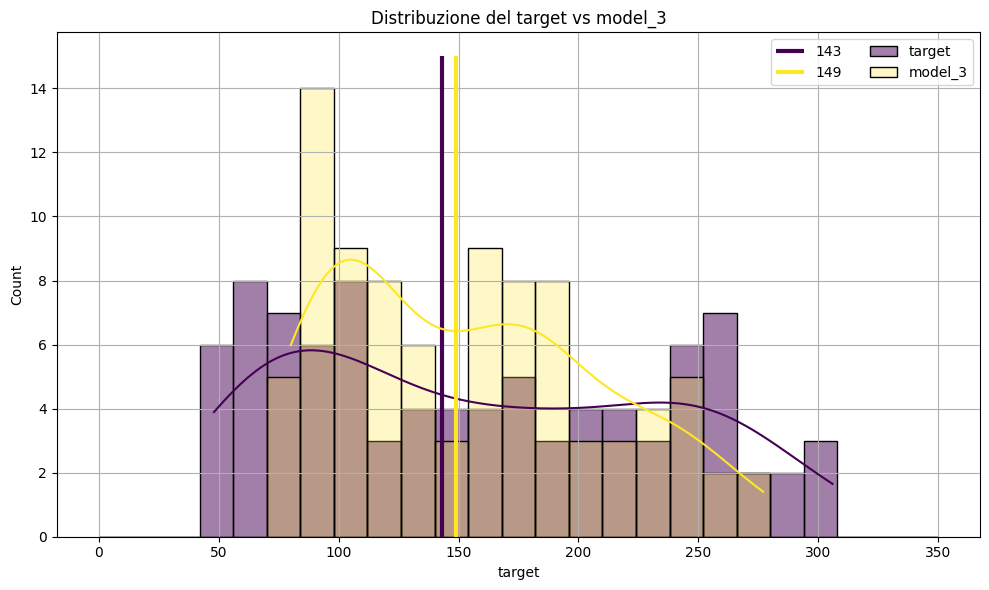

In [60]:
# imposto il grafico delle distribuzioni
plt.figure(figsize=(10, 6))
plt.grid()

# calcolo mediane
median_target = int(
    diabetes_test["target"].median()
)
median_target_pred = int(
    diabetes_test["target_pred"].median()
)


# grafico target
sns.histplot(
    data=diabetes_test,
    x="target",
    color=colors[0],
    alpha=0.5,
    binwidth=14,
    binrange=(0, 350),
    kde=True,
    label="target",
)
# mediana
plt.vlines(
    x=median_target,
    ymin=0,
    ymax=15,
    color=colors[0],
    linewidth=3,
    label=median_target
)

# grafico model
sns.histplot(
    data=diabetes_test,
    x="target_pred",
    color=colors[10],
    alpha=0.25,
    binwidth=14,
    binrange=(0, 350),
    kde=True,
    label="model_3",
)
#mediana
plt.vlines(
    x=median_target_pred,
    ymin=0,
    ymax=15,
    color=colors[10],
    linewidth=3,
    label=median_target_pred,
)

# imposto titolo, layout e legenda
plt.title("Distribuzione del target vs model_3")
plt.tight_layout()
plt.legend(ncol=2)

# Conclusioni


I risultati ottenuti sembrano in linea con le aspettative, il punteggio R2 è leggermente peggiorato rispetto a quello ottenuto durante la cross validation (da 0.476 a 0.466) ma comunque non si discosta molto da quel valore. Questo perchè i punteggi ottenuti sui fold di test nella cross validation tendono ad essere leggermente ottimistici.

Il punteggio di R2 è leggermente aumentato rispetto all'addestramento con baseline model, da 0.447 a 0.466.

Il punteggio MAPE è migliorato rispetto all'addestramento con baseline model, da 0.389 a 0.378.

Il vero miglioramento è stata la riduzione del punteggio R2 e l'incremento di MAPE sul train set.  
R2 è passato da 0.92 a 0.64 e MAPE da 0.149 a 0.33.
Questo indica che il modello è migliorato nel generalizzare su dati mai visti.

Si è ridotta la varianza del modello.

Il modello quindi riesce a spiegare circa il 47% della varianza del target ed ha un errore assoluto percentuale di circa il 38%.

Il grafico della distribuzione mostra che le predizioni sono più concentrate attorno al valore centrale rispetto ai dati reali, ma si può notare una certa somiglianza nella forma a "doppia gobba" della linea kde.

La mediana delle predizioni è 149, quella del target è di 143.

Non è una prestazione ottimale. Ipotizzo che la causa principale sia numero limitato di campioni del dataset.
